Dataset loaded. N_FEATURES_GLOBAL: 21
ACO stopped early at iter 20 due to stagnation.
GA stopped early at gen 36 due to stagnation.


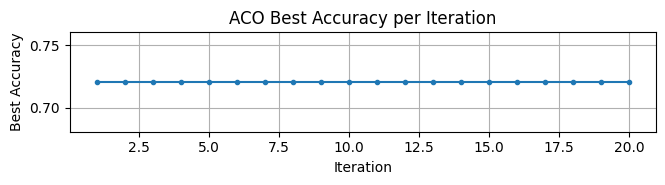

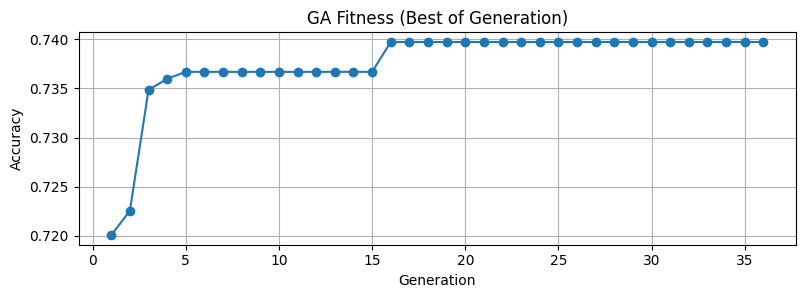

In [8]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif # Added for ACO
import threading
import traceback

# --- 1. Global Data Loading and Preparation (Same as before) ---
Y_TARGET_GLOBAL = None
X_UNSCALED_GLOBAL = None
X_SCALED_GLOBAL = None
N_FEATURES_GLOBAL = 0
SCALER_GLOBAL = StandardScaler()
X_train_ga, X_test_ga, y_train_ga, y_test_ga = None, None, None, None
try:
    df = pd.read_csv("data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
    if "Diabetes_binary" in df.columns:
        Y_TARGET_GLOBAL = df["Diabetes_binary"].values
        X_UNSCALED_GLOBAL = df.drop("Diabetes_binary", axis=1).values
    else:
        Y_TARGET_GLOBAL = df.iloc[:, 0].values
        X_UNSCALED_GLOBAL = df.iloc[:, 1:].values
    if X_UNSCALED_GLOBAL is not None:
        N_FEATURES_GLOBAL = X_UNSCALED_GLOBAL.shape[1]
        X_SCALED_GLOBAL = SCALER_GLOBAL.fit_transform(X_UNSCALED_GLOBAL)
        X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
            X_SCALED_GLOBAL, Y_TARGET_GLOBAL, test_size=0.2, stratify=Y_TARGET_GLOBAL, random_state=42)
        print(f"Dataset loaded. N_FEATURES_GLOBAL: {N_FEATURES_GLOBAL}")
    else: raise ValueError("X_UNSCALED_GLOBAL could not be determined.")
except FileNotFoundError:
    messagebox.showerror("Fatal Error", "Dataset file not found. App cannot start."); exit()
except Exception as e:
    messagebox.showerror("Fatal Error", f"Data loading error: {e}. App cannot start."); exit()

# --- GA Core Functions (Same as before) ---
def evaluate_ga(individual, X_train_data, X_test_data, y_train_data, y_test_data):
    if np.sum(individual) == 0: return 0
    selected_indices = np.where(individual == 1)[0]
    if len(selected_indices) == 0: return 0
    if X_train_data is None or X_train_data.shape[1] == 0 or np.any(selected_indices >= X_train_data.shape[1]): return 0
    X_train_subset, X_test_subset = X_train_data[:, selected_indices], X_test_data[:, selected_indices]
    if X_train_subset.shape[1] == 0: return 0
    clf = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0, random_state=42)
    try: clf.fit(X_train_subset, y_train_data); return accuracy_score(y_test_data, clf.predict(X_test_subset))
    except Exception: return 0
def init_population_ga(pop_size, n_features_available, n_selected_target):
    population = []
    if n_features_available == 0:
        for _ in range(pop_size): population.append(np.zeros(n_features_available, dtype=int))
        return population
    for _ in range(pop_size):
        ind = np.zeros(n_features_available, dtype=int)
        num_to_select = min(n_selected_target, n_features_available)
        if num_to_select > 0: ind[np.random.choice(n_features_available, num_to_select, replace=False)] = 1
        population.append(ind)
    return population
def enforce_feature_count(ind, n_selected):
    ind = np.array(ind, dtype=int); ones = np.where(ind == 1)[0]; zeros = np.where(ind == 0)[0]
    if len(ones) > n_selected:
        num_to_zero = len(ones) - n_selected
        if num_to_zero > 0 and len(ones) > 0: ind[np.random.choice(ones, num_to_zero, replace=False)] = 0
    elif len(ones) < n_selected:
        num_to_one = n_selected - len(ones)
        if num_to_one > 0 and len(zeros) > 0: ind[np.random.choice(zeros, num_to_one, replace=False)] = 1
    return ind
def one_point_crossover(p1, p2, n_selected):
    if len(p1) <= 1: return enforce_feature_count(p1.copy(), n_selected)
    point = np.random.randint(1, len(p1)); child = np.concatenate([p1[:point], p2[point:]])
    return enforce_feature_count(child, n_selected)
def two_point_crossover(p1, p2, n_selected):
    if len(p1) < 2: return enforce_feature_count(p1.copy(), n_selected)
    point1, point2 = sorted(np.random.choice(len(p1), 2, replace=False)); child = np.concatenate([p1[:point1], p2[point1:point2], p1[point2:]])
    return enforce_feature_count(child, n_selected)
def uniform_crossover(p1, p2, n_selected):
    if len(p1) == 0: return np.array([], dtype=int)
    mask = np.random.rand(len(p1)) > 0.5; child = np.where(mask, p1, p2)
    return enforce_feature_count(child, n_selected)
def flip_bit_mutation(ind, n_selected):
    if len(ind) == 0: return ind
    ind_copy = ind.copy(); idx = np.random.randint(len(ind_copy)); ind_copy[idx] = 1 - ind_copy[idx]
    return enforce_feature_count(ind_copy, n_selected)
def random_reset_mutation(ind, n_selected):
    if len(ind) == 0: return ind
    ind_copy = ind.copy(); idx = np.random.randint(len(ind_copy)); ind_copy[idx] = np.random.randint(2)
    return enforce_feature_count(ind_copy, n_selected)
def swap_mutation(ind, n_selected):
    if len(ind) < 2: return enforce_feature_count(ind.copy(), n_selected)
    ind_copy = ind.copy(); ones = np.where(ind_copy == 1)[0]; zeros = np.where(ind_copy == 0)[0]
    if len(ones) > 0 and len(zeros) > 0:
        idx1, idx2 = np.random.choice(ones), np.random.choice(zeros); ind_copy[idx1], ind_copy[idx2] = ind_copy[idx2], ind_copy[idx1]
    return ind_copy
def tournament_selection(pop, scores, k):
    actual_k = min(k, len(pop))
    if actual_k == 0 or not pop: return pop[np.random.randint(len(pop))] if pop else None
    selected_indices = np.random.choice(len(pop), actual_k, replace=False)
    best_score_in_tournament, best_individual_index = -1, -1
    for i in selected_indices:
        if scores[i] > best_score_in_tournament: best_score_in_tournament, best_individual_index = scores[i], i
    return pop[best_individual_index] if best_individual_index != -1 else pop[selected_indices[0]]
def stochastic_universal_sampling(pop, scores):
    if not pop: return None
    total_score = np.sum(scores)
    if total_score == 0: return pop[np.random.randint(len(pop))]
    probs, cum_probs = np.array(scores) / total_score, np.cumsum(np.array(scores) / total_score)
    pointer = np.random.uniform(0, 1)
    for i, cp_val in enumerate(cum_probs):
        if pointer <= cp_val: return pop[i]
    return pop[-1]
def roulette_wheel_selection(pop, scores):
    if not pop: return None
    min_score = min(scores) if scores.size > 0 else 0
    adjusted_scores = [s - min_score + 1e-6 for s in scores]; total_adjusted = sum(adjusted_scores)
    if total_adjusted == 0: return pop[np.random.randint(len(pop))]
    pick, current = np.random.uniform(0, total_adjusted), 0
    for ind, score in zip(pop, adjusted_scores):
        current += score
        if current > pick: return ind
    return pop[-1]

# --- GAApp Class (MODIFIED for stagnation) ---
class GAApp:
    def __init__(self, master_window):
        self.master = master_window; self.master.title("Genetic Algorithm Configuration"); self.master.geometry("850x750") # Adjusted height
        self.X_train_ga_specific, self.X_test_ga_specific, self.y_train_ga_specific, self.y_test_ga_specific = X_train_ga, X_test_ga, y_train_ga, y_test_ga
        self.N_FEATURES_ga = N_FEATURES_GLOBAL
        if self.X_train_ga_specific is None: messagebox.showerror("GA Error", "GA training data not available.", parent=self.master); self.master.destroy(); return
        
        param_frame = ttk.LabelFrame(self.master, text="GA Parameters"); param_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        ttk.Label(param_frame, text="Population Size:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        self.pop_size_var = tk.IntVar(value=50)
        self.pop_size_scale = ttk.Scale(param_frame, from_=10, to=200, orient="horizontal", variable=self.pop_size_var, command=lambda s: self.pop_size_var.set(int(float(s)))); self.pop_size_scale.grid(row=0, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.pop_size_var).grid(row=0, column=2, padx=5, pady=5, sticky="w"); self.pop_size_var.trace_add("write", self._update_tournament_k_scale_range)
        
        ttk.Label(param_frame, text="Number of Generations:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        self.n_gen_var = tk.IntVar(value=100)
        self.n_gen_scale = ttk.Scale(param_frame, from_=10, to=500, orient="horizontal", variable=self.n_gen_var, command=lambda s: self.n_gen_var.set(int(float(s))))
        self.n_gen_scale.grid(row=1, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.n_gen_var).grid(row=1, column=2, padx=5, pady=5, sticky="w")
        self.n_gen_var.trace_add("write", self._update_stagnation_scale_range_ga) # Update stagnation scale range when n_gen changes

        ttk.Label(param_frame, text="Mutation Probability:").grid(row=2, column=0, padx=5, pady=5, sticky="w")
        self.mut_prob_var = tk.DoubleVar(value=0.2); mutation_values = [f"{i*0.1:.1f}" for i in range(11)]
        self.mut_prob_combobox = ttk.Combobox(param_frame, textvariable=self.mut_prob_var, values=mutation_values, state="readonly", width=5); self.mut_prob_combobox.grid(row=2, column=1, padx=5, pady=5, sticky="ew"); self.mut_prob_combobox.set(f"{self.mut_prob_var.get():.1f}")
        ttk.Label(param_frame, textvariable=self.mut_prob_var).grid(row=2, column=2, padx=5, pady=5, sticky="w")
        
        ttk.Label(param_frame, text="Tournament Size (k):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.tournament_k_var = tk.IntVar(value=3)
        self.tournament_k_scale = ttk.Scale(param_frame, from_=2, to=max(2,self.pop_size_var.get()), orient="horizontal", variable=self.tournament_k_var, command=lambda s: self.tournament_k_var.set(int(float(s)))); self.tournament_k_scale.grid(row=3, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.tournament_k_var).grid(row=3, column=2, padx=5, pady=5, sticky="w"); self._update_tournament_k_scale_range()
        
        ttk.Label(param_frame, text="Number of Features to Select:").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.n_selected_features_var = tk.IntVar(value=min(5, self.N_FEATURES_ga if self.N_FEATURES_ga > 0 else 1))
        self.n_selected_features_scale = ttk.Scale(param_frame, from_=1, to=max(1, self.N_FEATURES_ga), orient="horizontal", variable=self.n_selected_features_var, command=lambda s: self.n_selected_features_var.set(int(float(s)))); self.n_selected_features_scale.grid(row=4, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.n_selected_features_var).grid(row=4, column=2, padx=5, pady=5, sticky="w")
        if self.N_FEATURES_ga == 0: self.n_selected_features_scale.config(state=tk.DISABLED)

        # Stagnation Iterations (GA) - NEW
        ttk.Label(param_frame, text="Stagnation Iterations:").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.stagnation_iters_ga_var = tk.IntVar(value=20) 
        self.stagnation_iters_ga_scale = ttk.Scale(param_frame, from_=5, to=self.n_gen_var.get(), orient="horizontal", variable=self.stagnation_iters_ga_var, command=lambda s: self.stagnation_iters_ga_var.set(int(float(s))))
        self.stagnation_iters_ga_scale.grid(row=5, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.stagnation_iters_ga_var).grid(row=5, column=2, padx=5, pady=5, sticky="w")
        self._update_stagnation_scale_range_ga() # Initial call

        param_frame.columnconfigure(1, weight=1)
        
        operators_frame = ttk.LabelFrame(self.master, text="GA Operators"); operators_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        ttk.Label(operators_frame, text="Crossover Strategy:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        self.crossover_var = tk.StringVar(value="One Point"); ttk.Combobox(operators_frame, textvariable=self.crossover_var, values=["One Point", "Two Point", "Uniform"], state="readonly").grid(row=0, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(operators_frame, text="Mutation Strategy:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        self.mutation_var = tk.StringVar(value="Flip Bit"); ttk.Combobox(operators_frame, textvariable=self.mutation_var, values=["Flip Bit", "Random Reset", "Swap"], state="readonly").grid(row=1, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(operators_frame, text="Selection Strategy:").grid(row=2, column=0, padx=5, pady=5, sticky="w")
        self.selection_var = tk.StringVar(value="Tournament"); ttk.Combobox(operators_frame, textvariable=self.selection_var, values=["Tournament", "Stochastic Universal Sampling", "Roulette Wheel"], state="readonly").grid(row=2, column=1, padx=5, pady=5, sticky="ew")
        operators_frame.columnconfigure(1, weight=1)
        
        self.run_button = ttk.Button(self.master, text="Run Genetic Algorithm", command=self.run_ga_thread); self.run_button.grid(row=1, column=0, columnspan=2, pady=10)
        self.status_var = tk.StringVar(value="Ready to run GA."); ttk.Label(self.master, textvariable=self.status_var).grid(row=2, column=0, columnspan=2, pady=5, sticky="ew")
        
        results_frame = ttk.LabelFrame(self.master, text="GA Results"); results_frame.grid(row=3, column=0, columnspan=2, padx=10, pady=10, sticky="nsew")
        self.best_features_label = ttk.Label(results_frame, text="Best features selected (indices): "); self.best_features_label.grid(row=0, column=0, padx=5, pady=2, sticky="w")
        self.ga_accuracy_label = ttk.Label(results_frame, text="Best accuracy during GA (LogReg): "); self.ga_accuracy_label.grid(row=1, column=0, padx=5, pady=2, sticky="w")
        self.rf_accuracy_label = ttk.Label(results_frame, text="Accuracy with selected features (Random Forest): "); self.rf_accuracy_label.grid(row=2, column=0, padx=5, pady=2, sticky="w")
        self.figure, self.ax = plt.subplots(figsize=(7, 3)); self.canvas = FigureCanvasTkAgg(self.figure, master=results_frame); self.canvas_widget = self.canvas.get_tk_widget(); self.canvas_widget.grid(row=3, column=0, columnspan=2, padx=5, pady=5, sticky="nsew")
        results_frame.columnconfigure(0, weight=1); results_frame.rowconfigure(3, weight=1)
        self.master.columnconfigure(0, weight=1); self.master.columnconfigure(1, weight=1); self.master.rowconfigure(3, weight=1)

    def _update_tournament_k_scale_range(self, *args):
        current_pop_size = self.pop_size_var.get(); new_to = max(2, current_pop_size); self.tournament_k_scale.config(to=new_to)
        if self.tournament_k_var.get() > new_to: self.tournament_k_var.set(new_to)
        current_from = self.tournament_k_scale.cget("from")
        if self.tournament_k_var.get() < current_from: self.tournament_k_var.set(int(current_from))

    def _update_stagnation_scale_range_ga(self, *args): # NEW method
        current_n_gen = self.n_gen_var.get()
        new_to = max(5, current_n_gen) 
        self.stagnation_iters_ga_scale.config(to=new_to)
        if self.stagnation_iters_ga_var.get() > new_to:
            self.stagnation_iters_ga_var.set(new_to)
        current_from_val = self.stagnation_iters_ga_scale.cget("from")
        if self.stagnation_iters_ga_var.get() < current_from_val:
            self.stagnation_iters_ga_var.set(int(current_from_val))

    def run_ga_thread(self):
        self.run_button.config(state=tk.DISABLED); self.status_var.set("Validating GA parameters...")
        if self.N_FEATURES_ga == 0: messagebox.showerror("GA Error", "N_FEATURES_ga is 0.", parent=self.master); self.status_var.set("Error: No features for GA."); self.run_button.config(state=tk.NORMAL); return
        self.status_var.set("Running GA..."); self.ga_thread_instance = threading.Thread(target=self.run_genetic_algorithm_instance, daemon=True); self.ga_thread_instance.start()

    def run_genetic_algorithm_instance(self): # MODIFIED for stagnation
        try:
            pop_size = self.pop_size_var.get()
            n_gen = self.n_gen_var.get()
            mut_prob = self.mut_prob_var.get()
            tournament_k = self.tournament_k_var.get()
            n_selected_features = self.n_selected_features_var.get()
            stagnation_patience = self.stagnation_iters_ga_var.get() # NEW

            c_map = {"One Point": one_point_crossover, "Two Point": two_point_crossover, "Uniform": uniform_crossover}
            m_map = {"Flip Bit": flip_bit_mutation, "Random Reset": random_reset_mutation, "Swap": swap_mutation}
            s_map = {"Tournament": tournament_selection, "SUS": stochastic_universal_sampling, "Roulette": roulette_wheel_selection}
            
            c_func = c_map[self.crossover_var.get()]
            m_func = m_map[self.mutation_var.get()]
            s_func_name = self.selection_var.get().replace("Stochastic Universal Sampling", "SUS").replace("Roulette Wheel", "Roulette")
            s_func = s_map[s_func_name]

            pop = init_population_ga(pop_size, self.N_FEATURES_ga, n_selected_features)
            best_acc_overall, best_ind_overall, fitness_over_time = 0.0, None, []
            stagnation_counter = 0 # NEW

            for gen in range(n_gen):
                self.master.after(0, self.status_var.set, f"GA Gen {gen + 1}/{n_gen}, Stagnation: {stagnation_counter}/{stagnation_patience}")
                
                scores = np.array([evaluate_ga(ind, self.X_train_ga_specific, self.X_test_ga_specific, self.y_train_ga_specific, self.y_test_ga_specific) for ind in pop])
                if not scores.size: 
                    self.master.after(0, self.status_var.set, "GA stopped: No scores.")
                    break

                current_gen_best_score = np.max(scores)
                fitness_over_time.append(current_gen_best_score) # Log best score of current gen

                if current_gen_best_score > best_acc_overall:
                    best_acc_overall = current_gen_best_score
                    best_ind_overall = pop[np.argmax(scores)].copy()
                    stagnation_counter = 0 # Reset stagnation counter
                else:
                    stagnation_counter += 1 # Increment stagnation counter

                if stagnation_counter >= stagnation_patience:
                    msg = f"GA stopped early at gen {gen + 1} due to stagnation."
                    print(msg)
                    self.master.after(0, self.status_var.set, msg)
                    break
                
                # Elitism: Keep the best individual found so far
                new_pop = [best_ind_overall.copy() if best_ind_overall is not None else pop[np.random.randint(len(pop))].copy()]
                
                while len(new_pop) < pop_size:
                    p_args = (pop, scores, tournament_k) if s_func_name == "Tournament" else (pop, scores)
                    p1, p2 = s_func(*p_args), s_func(*p_args)
                    if p1 is None or p2 is None: # Fallback if selection fails
                        p1, p2 = pop[np.random.randint(len(pop))], pop[np.random.randint(len(pop))]
                    
                    child = c_func(p1, p2, n_selected_features)
                    if np.random.rand() < mut_prob:
                        child = m_func(child, n_selected_features)
                    new_pop.append(child)
                pop = new_pop[:pop_size]
            
            self.master.after(0, self.update_ga_results, best_ind_overall, best_acc_overall, fitness_over_time)
        except Exception as e:
            err_msg, detailed_err = traceback.format_exc(), f"GA Error: {e}"
            self.master.after(0, self.status_var.set, detailed_err)
            self.master.after(0, lambda e=e, d=err_msg: messagebox.showerror("GA Error", f"Error: {e}\n\n{d}", parent=self.master))
        finally:
            self.master.after(0, lambda: self.run_button.config(state=tk.NORMAL))

    def update_ga_results(self, best_individual, ga_accuracy, fitness_over_time):
        # (Same as before, ensure fitness_over_time is plotted correctly)
        self.status_var.set("GA Finished!")
        if best_individual is not None:
            sel_idx = np.where(best_individual == 1)[0]
            self.best_features_label.config(text=f"Best features (GA): {sel_idx.tolist() if len(sel_idx) > 0 else 'None'}")
            self.ga_accuracy_label.config(text=f"Best accuracy (GA LogReg): {ga_accuracy:.4f}")
            if len(sel_idx) > 0 and self.X_train_ga_specific is not None:
                valid_idx = sel_idx[sel_idx < self.X_train_ga_specific.shape[1]]
                if len(valid_idx) > 0:
                    rf = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf.fit(self.X_train_ga_specific[:, valid_idx], self.y_train_ga_specific)
                    rf_preds = rf.predict(self.X_test_ga_specific[:, valid_idx]); rf_acc = accuracy_score(self.y_test_ga_specific, rf_preds)
                    self.rf_accuracy_label.config(text=f"Accuracy (GA RF): {rf_acc:.4f}")
                else: self.rf_accuracy_label.config(text="Accuracy (GA RF): N/A (No valid features)")
            else: self.rf_accuracy_label.config(text="Accuracy (GA RF): N/A")
        self.ax.clear();
        if fitness_over_time: self.ax.plot(range(1, len(fitness_over_time) + 1), fitness_over_time, marker='o', linestyle='-')
        self.ax.set_title('GA Fitness (Best of Generation)'); self.ax.set_xlabel('Generation'); self.ax.set_ylabel('Accuracy')
        self.ax.grid(True); self.figure.tight_layout(); self.canvas.draw()


# --- HarmonySearchUtils Class (MODIFIED for stagnation) ---
class HarmonySearchUtils:
    def __init__(self, X_data_unscaled, y_data_target, n_total_features):
        self.X, self.y, self.N_FEATURES = X_data_unscaled, y_data_target, n_total_features
    
    def initialize_harmony_memory_hs(self, hms, target_dimension):
        # (Same as before)
        mem = []
        if self.N_FEATURES == 0 or target_dimension > self.N_FEATURES:
            for _ in range(hms): mem.append(np.array([], dtype=int)); return mem
        for _ in range(hms):
            actual_size = min(target_dimension, self.N_FEATURES)
            mem.append(np.random.choice(range(self.N_FEATURES), size=actual_size, replace=False) if actual_size > 0 else np.array([], dtype=int))
        return mem

    def fitness_hs(self, harmony_indices):
        # (Same as before)
        if not isinstance(harmony_indices, (list, np.ndarray)) or len(harmony_indices) == 0: return 0.0
        try:
            harmony_indices = [int(i) for i in harmony_indices]
            if not all(0 <= i < self.X.shape[1] for i in harmony_indices): return 0.0
        except ValueError: return 0.0
        X_sub = self.X[:, harmony_indices]
        if X_sub.shape[1] == 0: return 0.0
        X_tr, X_v, y_tr, y_v = train_test_split(X_sub, self.y, test_size=0.3, random_state=42, stratify=self.y if np.unique(self.y).size > 1 else None)
        model = LogisticRegression(max_iter=1000, solver='liblinear')
        try: model.fit(X_tr, y_tr); return model.score(X_v, y_v)
        except Exception: return 0.0

    def harmony_search_algorithm_hs(self, hms, hmcr, par, target_dim, max_iter, stagnation_patience, status_update_func=None): # MODIFIED
        h_mem = self.initialize_harmony_memory_hs(hms, target_dim)
        h_scores = [self.fitness_hs(h) for h in h_mem]
        
        best_overall_score_hs = np.max(h_scores) if h_scores else 0.0
        best_harmony_overall = h_mem[np.argmax(h_scores)].copy() if h_scores and np.argmax(h_scores) < len(h_mem) else (np.array([]) if not h_mem else h_mem[0].copy()) # Ensure best_harmony_overall is initialized safely


        history_best_scores = [] # For plotting best score at each iteration
        stagnation_counter = 0 # NEW

        for iteration in range(max_iter):
            if status_update_func: 
                status_update_func(f"HS Iteration {iteration + 1}/{max_iter}, Stagnation: {stagnation_counter}/{stagnation_patience}")
            
            new_h_idx = []
            for _ in range(target_dim): # Construct one dimension (feature index) at a time
                if np.random.rand() < hmcr: # Memory consideration
                    if any(len(h) > 0 for h in h_mem): # Ensure memory is not empty or full of empty harmonies
                        valid_harmonies = [h for h in h_mem if len(h) > 0]
                        if valid_harmonies:
                            chosen_harmony_for_dim = valid_harmonies[np.random.randint(len(valid_harmonies))]
                            if chosen_harmony_for_dim.size > 0: # Check if chosen harmony has features
                                f_val = np.random.choice(chosen_harmony_for_dim)
                            else: # Fallback if a chosen harmony is empty (should ideally not happen with good init)
                                f_val = np.random.randint(0, self.N_FEATURES)
                        else: # Fallback if no valid harmonies
                             f_val = np.random.randint(0, self.N_FEATURES)

                        if np.random.rand() < par: # Pitch adjustment
                            f_val = max(0, min(f_val + np.random.choice([-1, 1]), self.N_FEATURES - 1))
                    else: # Fallback if all harmonies in memory are empty
                        f_val = np.random.randint(0, self.N_FEATURES)
                else: # Random selection
                    f_val = np.random.randint(0, self.N_FEATURES)
                new_h_idx.append(f_val)
            
            new_h_idx = list(set(new_h_idx)) # Remove duplicates
            # Ensure target_dim features if possible
            while len(new_h_idx) < target_dim and self.N_FEATURES > len(new_h_idx):
                feat_to_add = np.random.randint(0, self.N_FEATURES)
                if feat_to_add not in new_h_idx:
                    new_h_idx.append(feat_to_add)
            new_h_idx = new_h_idx[:target_dim] # Trim if too many (e.g., if target_dim was initially 0)

            new_s = self.fitness_hs(new_h_idx)

            if h_scores: # If memory is not empty
                worst_idx = np.argmin(h_scores)
                if new_s > h_scores[worst_idx]:
                    h_mem[worst_idx] = np.array(new_h_idx)
                    h_scores[worst_idx] = new_s
            else: # Initialize memory if it was empty
                 h_mem.append(np.array(new_h_idx))
                 h_scores.append(new_s)


            current_iter_best_score = np.max(h_scores) if h_scores else 0.0
            history_best_scores.append(current_iter_best_score) # Log best score from current memory

            if current_iter_best_score > best_overall_score_hs:
                best_overall_score_hs = current_iter_best_score
                best_harmony_overall = h_mem[np.argmax(h_scores)].copy()
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter >= stagnation_patience:
                msg = f"HS stopped early at iter {iteration + 1} due to stagnation."
                print(msg)
                if status_update_func: status_update_func(msg)
                break
        
        if not h_scores: return np.array([]), 0, [] # Handle empty memory case
        # Final best is already tracked by best_overall_score_hs and best_harmony_overall
        return best_harmony_overall, best_overall_score_hs, history_best_scores


# --- HSApp Class (MODIFIED for stagnation) ---
class HSApp:
    def __init__(self, master_window):
        self.master = master_window; self.master.title("Harmony Search Configuration"); self.master.geometry("700x600") # Adjusted height
        self.hs_utils = HarmonySearchUtils(X_UNSCALED_GLOBAL, Y_TARGET_GLOBAL, N_FEATURES_GLOBAL)
        if X_UNSCALED_GLOBAL is None: messagebox.showerror("HS Error", "HS data not available.", parent=self.master); self.master.destroy(); return
        
        param_frame = ttk.LabelFrame(self.master, text="Harmony Search Parameters"); param_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew", columnspan=3)
        
        ttk.Label(param_frame, text="HMS:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        self.hms_var = tk.IntVar(value=20); ttk.Scale(param_frame, from_=5, to=100, orient="horizontal", variable=self.hms_var, command=lambda s: self.hms_var.set(int(float(s)))).grid(row=0, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.hms_var).grid(row=0, column=2, padx=5, pady=5, sticky="w")
        
        ttk.Label(param_frame, text="HMCR:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        self.hmcr_var = tk.DoubleVar(value=0.9); hmcr_v = [f"{i*0.1:.1f}" for i in range(11)]
        self.hmcr_cb = ttk.Combobox(param_frame, textvariable=self.hmcr_var, values=hmcr_v, state="readonly", width=5); self.hmcr_cb.grid(row=1, column=1, padx=5, pady=5, sticky="ew"); self.hmcr_cb.set(f"{self.hmcr_var.get():.1f}")
        ttk.Label(param_frame, textvariable=self.hmcr_var).grid(row=1, column=2, padx=5, pady=5, sticky="w")
        
        ttk.Label(param_frame, text="PAR:").grid(row=2, column=0, padx=5, pady=5, sticky="w")
        self.par_var = tk.DoubleVar(value=0.3); par_v = [f"{i*0.1:.1f}" for i in range(11)]
        self.par_cb = ttk.Combobox(param_frame, textvariable=self.par_var, values=par_v, state="readonly", width=5); self.par_cb.grid(row=2, column=1, padx=5, pady=5, sticky="ew"); self.par_cb.set(f"{self.par_var.get():.1f}")
        ttk.Label(param_frame, textvariable=self.par_var).grid(row=2, column=2, padx=5, pady=5, sticky="w")
        
        ttk.Label(param_frame, text="Max Iterations:").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.max_iter_var = tk.IntVar(value=100)
        self.max_iter_scale = ttk.Scale(param_frame, from_=50, to=5000, orient="horizontal", variable=self.max_iter_var, command=lambda s: self.max_iter_var.set(int(float(s))))
        self.max_iter_scale.grid(row=3, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.max_iter_var).grid(row=3, column=2, padx=5, pady=5, sticky="w")
        self.max_iter_var.trace_add("write", self._update_stagnation_scale_range_hs) # Update stagnation

        ttk.Label(param_frame, text="Target Dimension:").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.target_dim_var = tk.IntVar(value=min(3, N_FEATURES_GLOBAL if N_FEATURES_GLOBAL > 0 else 1))
        self.target_dim_scale = ttk.Scale(param_frame, from_=1, to=max(1, N_FEATURES_GLOBAL), orient="horizontal", variable=self.target_dim_var, command=lambda s: self.target_dim_var.set(int(float(s)))); self.target_dim_scale.grid(row=4, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.target_dim_var).grid(row=4, column=2, padx=5, pady=5, sticky="w")
        if N_FEATURES_GLOBAL == 0: self.target_dim_scale.config(state=tk.DISABLED)

        # Stagnation Iterations (HS) - NEW
        ttk.Label(param_frame, text="Stagnation Iterations:").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.stagnation_iters_hs_var = tk.IntVar(value=20)
        self.stagnation_iters_hs_scale = ttk.Scale(param_frame, from_=5, to=self.max_iter_var.get(), orient="horizontal", variable=self.stagnation_iters_hs_var, command=lambda s: self.stagnation_iters_hs_var.set(int(float(s))))
        self.stagnation_iters_hs_scale.grid(row=5, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.stagnation_iters_hs_var).grid(row=5, column=2, padx=5, pady=5, sticky="w")
        self._update_stagnation_scale_range_hs() # Initial call

        param_frame.columnconfigure(1, weight=1)
        
        self.run_hs_button = ttk.Button(self.master, text="Run Harmony Search", command=self.run_hs_thread); self.run_hs_button.grid(row=1, column=0, columnspan=3, pady=10)
        self.hs_status_var = tk.StringVar(value="Ready for Harmony Search."); ttk.Label(self.master, textvariable=self.hs_status_var).grid(row=2, column=0, columnspan=3, pady=5, sticky="ew")
        
        hs_res_frame = ttk.LabelFrame(self.master, text="HS Results"); hs_res_frame.grid(row=3, column=0, columnspan=3, padx=10, pady=10, sticky="nsew")
        self.hs_best_feat_lbl = ttk.Label(hs_res_frame, text="Best Features (HS): "); self.hs_best_feat_lbl.pack(pady=2, anchor="w")
        self.hs_acc_lbl = ttk.Label(hs_res_frame, text="Best Accuracy (HS LogReg): "); self.hs_acc_lbl.pack(pady=2, anchor="w")
        self.hs_fig, self.hs_ax = plt.subplots(figsize=(6, 2.5)); self.hs_canvas = FigureCanvasTkAgg(self.hs_fig, master=hs_res_frame); self.hs_canvas_widget = self.hs_canvas.get_tk_widget(); self.hs_canvas_widget.pack(fill=tk.BOTH, expand=True, pady=5)
        self.master.rowconfigure(3, weight=1); self.master.columnconfigure(0, weight=1)

    def _update_stagnation_scale_range_hs(self, *args): # NEW method
        current_max_iter = self.max_iter_var.get()
        new_to = max(5, current_max_iter)
        self.stagnation_iters_hs_scale.config(to=new_to)
        if self.stagnation_iters_hs_var.get() > new_to:
            self.stagnation_iters_hs_var.set(new_to)
        current_from_val = self.stagnation_iters_hs_scale.cget("from")
        if self.stagnation_iters_hs_var.get() < current_from_val:
            self.stagnation_iters_hs_var.set(int(current_from_val))

    def run_hs_thread(self):
        self.run_hs_button.config(state=tk.DISABLED); self.hs_status_var.set("Validating HS params...")
        if N_FEATURES_GLOBAL == 0 or self.target_dim_var.get() > N_FEATURES_GLOBAL or self.target_dim_var.get() <= 0:
            err_msg = "N_FEATURES_GLOBAL is 0." if N_FEATURES_GLOBAL == 0 else f"Target dimension invalid for {N_FEATURES_GLOBAL} features."
            messagebox.showerror("HS Error", err_msg, parent=self.master); self.hs_status_var.set("Error: Invalid params."); self.run_hs_button.config(state=tk.NORMAL); return
        self.hs_status_var.set("Running Harmony Search..."); self.hs_thread = threading.Thread(target=self.run_harmony_search_instance, daemon=True); self.hs_thread.start()

    def _update_hs_status(self, message): self.master.after(0, self.hs_status_var.set, message)

    def run_harmony_search_instance(self): # MODIFIED
        try:
            hms = self.hms_var.get()
            hmcr = self.hmcr_var.get()
            par = self.par_var.get()
            t_dim = self.target_dim_var.get()
            m_iter = self.max_iter_var.get()
            stagnation_patience_hs = self.stagnation_iters_hs_var.get() # NEW

            best_f, best_s, fit_time = self.hs_utils.harmony_search_algorithm_hs(
                hms, hmcr, par, t_dim, m_iter, stagnation_patience_hs, # Pass stagnation_patience
                status_update_func=self._update_hs_status
            )
            self.master.after(0, self.update_hs_results, best_f, best_s, fit_time)
        except Exception as e:
            err, d_err = traceback.format_exc(), f"HS Error: {e}"
            self.master.after(0, self.hs_status_var.set, d_err)
            self.master.after(0, lambda e=e, d=err: messagebox.showerror("HS Error", f"Error: {e}\n\n{d}", parent=self.master))
        finally:
            self.master.after(0, lambda: self.run_hs_button.config(state=tk.NORMAL))

    def update_hs_results(self, best_features, best_score, fitness_hs_over_time):
        # (Same as before, ensure fitness_hs_over_time is plotted correctly)
        self.hs_status_var.set("Harmony Search Finished!")
        self.hs_best_feat_lbl.config(text=f"Best Features (HS): {best_features.tolist() if isinstance(best_features, np.ndarray) else best_features}")
        self.hs_acc_lbl.config(text=f"Best Accuracy (HS LogReg): {best_score:.4f}")
        self.hs_ax.clear();
        if fitness_hs_over_time: self.hs_ax.plot(range(1, len(fitness_hs_over_time) + 1), fitness_hs_over_time, marker='.', linestyle='-')
        self.hs_ax.set_title('HS Best Fitness per Iteration'); self.hs_ax.set_xlabel('Iteration'); self.hs_ax.set_ylabel('Score')
        self.hs_ax.grid(True); self.hs_fig.tight_layout(); self.hs_canvas.draw()


# --- ACOUtils Class (MODIFIED for stagnation) ---
class ACOUtils:
    def __init__(self, X_data_unscaled, y_data_target, n_total_features):
        self.X_aco = X_data_unscaled
        self.y_aco = y_data_target
        self.N_FEATURES_ACO = n_total_features
        self.model_aco = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

    def fitness_aco(self, features_indices):
        # (Same as before)
        if not isinstance(features_indices, (list, np.ndarray)) or len(features_indices) == 0: return 0.0
        try: 
            features_indices = [int(i) for i in features_indices]
            if not all(0 <= i < self.X_aco.shape[1] for i in features_indices): return 0.0
        except ValueError: return 0.0
        unique_features_indices = sorted(list(set(features_indices)))
        if not unique_features_indices: return 0.0
        Xt_subset = self.X_aco[:, unique_features_indices]
        if Xt_subset.shape[1] == 0: return 0.0
        stratify_target = self.y_aco if np.unique(self.y_aco).size > 1 else None
        X_train, X_test, y_train, y_test = train_test_split(Xt_subset, self.y_aco, test_size=0.2, stratify=stratify_target, random_state=42)
        try:
            self.model_aco.fit(X_train, y_train)
            preds = self.model_aco.predict(X_test)
            return accuracy_score(y_test, preds)
        except Exception: return 0.0

    def select_features_aco(self, available_indices, heuristic_info, pheromone_levels, num_features_to_choose, alpha, beta):
        # (Same as before)
        selected_features = []
        current_available = list(available_indices) 
        if not current_available or num_features_to_choose == 0: return []
        num_to_pick = min(num_features_to_choose, len(current_available))
        for _ in range(num_to_pick):
            if not current_available: break 
            probs = []
            for f_idx in current_available:
                tau = pheromone_levels.get(f_idx, 1e-9) ** alpha 
                eta = heuristic_info.get(f_idx, 1e-9) ** beta   
                probs.append(tau * eta)
            probs = np.array(probs, dtype=float)
            if np.sum(probs) == 0 or np.any(np.isnan(probs)) or np.any(np.isinf(probs)):
                chosen_idx_in_available = np.random.choice(len(current_available))
                chosen_feature = current_available[chosen_idx_in_available]
            else:
                probs = probs / np.sum(probs) 
                chosen_feature = np.random.choice(current_available, p=probs)
            selected_features.append(chosen_feature)
            current_available.remove(chosen_feature) 
        return selected_features

    def run_aco_algorithm(self, max_iterations, num_ants, num_features_to_choose, alpha, beta, evaporation_rate, stagnation_patience, status_update_func=None): # MODIFIED
        all_feature_indices = list(range(self.N_FEATURES_ACO))
        best_score_overall = 0.0
        best_features_overall = []
        iteration_best_scores_history = [] # For plotting
        stagnation_counter = 0 # NEW

        if self.X_aco.shape[0] > 1 and self.N_FEATURES_ACO > 0:
            mi_scores = mutual_info_classif(self.X_aco, self.y_aco, random_state=42)
            mi_scores_normalized = mi_scores / (np.max(mi_scores) + 1e-9) if np.max(mi_scores) > 0 else mi_scores
        else:
            mi_scores_normalized = np.ones(self.N_FEATURES_ACO) * 1e-6
        heuristic_info = {idx: mi_scores_normalized[idx] + 1e-9 for idx in all_feature_indices}
        pheromone_levels = {idx: 1.0 for idx in all_feature_indices}

        for iteration in range(max_iterations):
            previous_best_score_for_stagnation = best_score_overall # Store before this iteration's updates

            current_iteration_ant_solutions = [] 
            iteration_max_fitness_this_iter = 0.0 

            for ant_num in range(num_ants):
                selected_f_indices = self.select_features_aco(
                    all_feature_indices, heuristic_info, pheromone_levels,
                    num_features_to_choose, alpha, beta
                )
                if not selected_f_indices: continue
                current_fitness = self.fitness_aco(selected_f_indices)
                current_iteration_ant_solutions.append((selected_f_indices, current_fitness))

                # Update overall best if current ant is better
                if current_fitness > best_score_overall:
                    best_score_overall = current_fitness
                    best_features_overall = selected_f_indices
            
            # Evaporate pheromones
            for f_idx in all_feature_indices:
                pheromone_levels[f_idx] *= (1.0 - evaporation_rate)
                pheromone_levels[f_idx] = max(pheromone_levels[f_idx], 0.01) # Pheromone floor

            # Deposit pheromones
            for features_sel, score in current_iteration_ant_solutions:
                for f_idx in features_sel:
                    pheromone_levels[f_idx] += score 

            # Stagnation Check
            if best_score_overall > previous_best_score_for_stagnation:
                stagnation_counter = 0
            else:
                stagnation_counter += 1
            
            iteration_best_scores_history.append(best_score_overall) # Log best score found up to this iteration

            if status_update_func:
                status_update_func(f"ACO Iteration {iteration + 1}/{max_iterations}, Best: {best_score_overall:.4f}, Stagnation: {stagnation_counter}/{stagnation_patience}")

            if stagnation_counter >= stagnation_patience:
                msg = f"ACO stopped early at iter {iteration + 1} due to stagnation."
                print(msg)
                if status_update_func: status_update_func(msg)
                break
        
        return best_features_overall, best_score_overall, iteration_best_scores_history


# --- ACOApp Class (MODIFIED for stagnation) ---
class ACOApp:
    def __init__(self, master_window):
        self.master = master_window
        self.master.title("Ant Colony Optimization Configuration")
        self.master.geometry("700x640") # Adjusted height for new param

        self.aco_utils = ACOUtils(X_UNSCALED_GLOBAL, Y_TARGET_GLOBAL, N_FEATURES_GLOBAL)

        if X_UNSCALED_GLOBAL is None:
            messagebox.showerror("ACO Error", "ACO data (unscaled) not available.", parent=self.master)
            self.master.destroy(); return

        param_frame = ttk.LabelFrame(self.master, text="ACO Parameters")
        param_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew", columnspan=3)

        ttk.Label(param_frame, text="Max Iterations:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        self.max_iter_var = tk.IntVar(value=50)
        self.max_iter_scale = ttk.Scale(param_frame, from_=10, to=500, orient="horizontal", variable=self.max_iter_var, command=lambda s: self.max_iter_var.set(int(float(s))))
        self.max_iter_scale.grid(row=0, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.max_iter_var).grid(row=0, column=2, padx=5, pady=5, sticky="w")
        self.max_iter_var.trace_add("write", self._update_stagnation_scale_range_aco) # Update stagnation

        ttk.Label(param_frame, text="Number of Ants:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        self.num_ants_var = tk.IntVar(value=10)
        ttk.Scale(param_frame, from_=5, to=50, orient="horizontal", variable=self.num_ants_var, command=lambda s: self.num_ants_var.set(int(float(s)))).grid(row=1, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.num_ants_var).grid(row=1, column=2, padx=5, pady=5, sticky="w")

        ttk.Label(param_frame, text="Features to Choose:").grid(row=2, column=0, padx=5, pady=5, sticky="w")
        self.num_features_chosen_var = tk.IntVar(value=min(3, N_FEATURES_GLOBAL if N_FEATURES_GLOBAL > 0 else 1))
        self.num_features_chosen_scale = ttk.Scale(param_frame, from_=1, to=max(1, N_FEATURES_GLOBAL), orient="horizontal", variable=self.num_features_chosen_var, command=lambda s: self.num_features_chosen_var.set(int(float(s))))
        self.num_features_chosen_scale.grid(row=2, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.num_features_chosen_var).grid(row=2, column=2, padx=5, pady=5, sticky="w")
        if N_FEATURES_GLOBAL == 0: self.num_features_chosen_scale.config(state=tk.DISABLED)

        ttk.Label(param_frame, text="Alpha (α):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.alpha_var = tk.DoubleVar(value=1.0)
        alpha_values = ["0.1", "0.5", "1.0", "2.0", "3.0", "5.0"]
        self.alpha_cb = ttk.Combobox(param_frame, textvariable=self.alpha_var, values=alpha_values, state="readonly", width=5)
        self.alpha_cb.grid(row=3, column=1, padx=5, pady=5, sticky="ew"); self.alpha_cb.set(f"{self.alpha_var.get():.1f}")
        ttk.Label(param_frame, textvariable=self.alpha_var).grid(row=3, column=2, padx=5, pady=5, sticky="w")

        ttk.Label(param_frame, text="Beta (β):").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.beta_var = tk.DoubleVar(value=1.0) 
        beta_values = ["0.0", "0.5", "1.0", "2.0", "3.0", "5.0"]
        self.beta_cb = ttk.Combobox(param_frame, textvariable=self.beta_var, values=beta_values, state="readonly", width=5)
        self.beta_cb.grid(row=4, column=1, padx=5, pady=5, sticky="ew"); self.beta_cb.set(f"{self.beta_var.get():.1f}")
        ttk.Label(param_frame, textvariable=self.beta_var).grid(row=4, column=2, padx=5, pady=5, sticky="w")
        
        ttk.Label(param_frame, text="Evaporation Rate (ρ):").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.evaporation_rate_var = tk.DoubleVar(value=0.1) 
        evaporation_values = ["0.01", "0.05", "0.1", "0.2", "0.3", "0.5","0.7","0.9"]
        self.evaporation_cb = ttk.Combobox(param_frame, textvariable=self.evaporation_rate_var, values=evaporation_values, state="readonly", width=5)
        self.evaporation_cb.grid(row=5, column=1, padx=5, pady=5, sticky="ew"); self.evaporation_cb.set(f"{self.evaporation_rate_var.get():.2f}")
        ttk.Label(param_frame, textvariable=self.evaporation_rate_var).grid(row=5, column=2, padx=5, pady=5, sticky="w")

        # Stagnation Iterations (ACO) - NEW
        ttk.Label(param_frame, text="Stagnation Iterations:").grid(row=6, column=0, padx=5, pady=5, sticky="w")
        self.stagnation_iters_aco_var = tk.IntVar(value=20) 
        self.stagnation_iters_aco_scale = ttk.Scale(param_frame, from_=5, to=self.max_iter_var.get(), orient="horizontal", variable=self.stagnation_iters_aco_var, command=lambda s: self.stagnation_iters_aco_var.set(int(float(s))))
        self.stagnation_iters_aco_scale.grid(row=6, column=1, padx=5, pady=5, sticky="ew")
        ttk.Label(param_frame, textvariable=self.stagnation_iters_aco_var).grid(row=6, column=2, padx=5, pady=5, sticky="w")
        self._update_stagnation_scale_range_aco() # Initial call

        param_frame.columnconfigure(1, weight=1)

        self.run_aco_button = ttk.Button(self.master, text="Run Ant Colony Optimization", command=self.run_aco_thread)
        self.run_aco_button.grid(row=1, column=0, columnspan=3, pady=10)
        self.aco_status_var = tk.StringVar(value="Ready for Ant Colony Optimization.")
        ttk.Label(self.master, textvariable=self.aco_status_var).grid(row=2, column=0, columnspan=3, pady=5, sticky="ew")
        
        aco_results_frame = ttk.LabelFrame(self.master, text="ACO Results")
        aco_results_frame.grid(row=3, column=0, columnspan=3, padx=10, pady=10, sticky="nsew")
        self.aco_best_features_label = ttk.Label(aco_results_frame, text="Best Features (ACO): ")
        self.aco_best_features_label.pack(pady=2, anchor="w")
        self.aco_accuracy_label = ttk.Label(aco_results_frame, text="Best Accuracy (ACO LogReg): ")
        self.aco_accuracy_label.pack(pady=2, anchor="w")
        
        self.aco_figure, self.aco_ax = plt.subplots(figsize=(6, 2.5))
        self.aco_canvas = FigureCanvasTkAgg(self.aco_figure, master=aco_results_frame)
        self.aco_canvas_widget = self.aco_canvas.get_tk_widget()
        self.aco_canvas_widget.pack(fill=tk.BOTH, expand=True, pady=5)
        self.master.rowconfigure(3, weight=1); self.master.columnconfigure(0, weight=1)

    def _update_stagnation_scale_range_aco(self, *args): # NEW method
        current_max_iter = self.max_iter_var.get()
        new_to = max(5, current_max_iter)
        self.stagnation_iters_aco_scale.config(to=new_to)
        if self.stagnation_iters_aco_var.get() > new_to:
            self.stagnation_iters_aco_var.set(new_to)
        current_from_val = self.stagnation_iters_aco_scale.cget("from")
        if self.stagnation_iters_aco_var.get() < current_from_val:
            self.stagnation_iters_aco_var.set(int(current_from_val))


    def run_aco_thread(self):
        self.run_aco_button.config(state=tk.DISABLED); self.aco_status_var.set("Validating ACO params...")
        if N_FEATURES_GLOBAL == 0 or self.num_features_chosen_var.get() > N_FEATURES_GLOBAL or self.num_features_chosen_var.get() <= 0:
            err = "N_FEATURES_GLOBAL is 0." if N_FEATURES_GLOBAL == 0 else f"Num features chosen invalid for {N_FEATURES_GLOBAL} features."
            messagebox.showerror("ACO Error", err, parent=self.master); self.aco_status_var.set("Error: Invalid params."); self.run_aco_button.config(state=tk.NORMAL); return
        self.aco_status_var.set("Running Ant Colony Optimization..."); self.aco_thread = threading.Thread(target=self.run_aco_instance, daemon=True); self.aco_thread.start()

    def _update_aco_status(self, message): self.master.after(0, self.aco_status_var.set, message)

    def run_aco_instance(self): # MODIFIED
        try:
            max_iter = self.max_iter_var.get()
            num_ants = self.num_ants_var.get()
            num_feat = self.num_features_chosen_var.get()
            alpha = self.alpha_var.get()
            beta = self.beta_var.get()
            evap_rate = self.evaporation_rate_var.get()
            stagnation_patience_aco = self.stagnation_iters_aco_var.get() # NEW
            
            best_f, best_s, iter_scores = self.aco_utils.run_aco_algorithm(
                max_iter, num_ants, num_feat, alpha, beta, evap_rate, 
                stagnation_patience_aco, # Pass stagnation patience
                status_update_func=self._update_aco_status
            )
            self.master.after(0, self.update_aco_results, best_f, best_s, iter_scores)
        except Exception as e:
            err, d_err = traceback.format_exc(), f"ACO Error: {e}"
            self.master.after(0, self.aco_status_var.set, d_err)
            self.master.after(0, lambda e=e, d=err: messagebox.showerror("ACO Error", f"Error: {e}\n\n{d}", parent=self.master))
        finally:
            self.master.after(0, lambda: self.run_aco_button.config(state=tk.NORMAL))

    def update_aco_results(self, best_features, best_score, iteration_best_scores):
        # (Same as before, ensure iteration_best_scores is plotted correctly)
        self.aco_status_var.set("Ant Colony Optimization Finished!")
        self.aco_best_features_label.config(text=f"Best Features (ACO): {best_features if best_features else 'None'}")
        self.aco_accuracy_label.config(text=f"Best Accuracy (ACO LogReg): {best_score:.4f}")
        self.aco_ax.clear();
        if iteration_best_scores: self.aco_ax.plot(range(1, len(iteration_best_scores) + 1), iteration_best_scores, marker='.', linestyle='-')
        self.aco_ax.set_title('ACO Best Accuracy per Iteration'); self.aco_ax.set_xlabel('Iteration'); self.aco_ax.set_ylabel('Best Accuracy')
        self.aco_ax.grid(True); self.aco_figure.tight_layout(); self.aco_canvas.draw()


# --- MainApp Class (No changes needed here for stagnation itself, but used for context) ---
class MainApp:
    def __init__(self, root):
        self.root = root; self.root.title("Feature Selection Tool"); self.root.geometry("380x150")
        self.current_algo_window = None
        ttk.Label(self.root, text="Choose Algorithm:", font=("Arial", 12)).pack(pady=10)
        self.algo_var = tk.StringVar(value="Genetic Algorithm")
        algo_options = ["Genetic Algorithm", "Harmony Search", "Ant Colony Optimization"]
        algo_menu = ttk.Combobox(self.root, textvariable=self.algo_var, values=algo_options, state="readonly", width=30, font=("Arial", 10))
        algo_menu.pack(pady=5)
        configure_button = ttk.Button(self.root, text="Configure & Run Selected Algorithm", command=self.open_algorithm_window, width=35)
        configure_button.pack(pady=10)

    def open_algorithm_window(self):
        selected_algo = self.algo_var.get()
        if self.current_algo_window and self.current_algo_window.winfo_exists(): self.current_algo_window.destroy()
        self.current_algo_window = tk.Toplevel(self.root)
        
        data_loaded_properly = True 
        if selected_algo == "Genetic Algorithm":
            if X_SCALED_GLOBAL is None or Y_TARGET_GLOBAL is None: data_loaded_properly = False
            if data_loaded_properly: GAApp(self.current_algo_window)
        elif selected_algo == "Harmony Search":
            if X_UNSCALED_GLOBAL is None or Y_TARGET_GLOBAL is None: data_loaded_properly = False
            if data_loaded_properly: HSApp(self.current_algo_window)
        elif selected_algo == "Ant Colony Optimization": 
            if X_UNSCALED_GLOBAL is None or Y_TARGET_GLOBAL is None: data_loaded_properly = False
            if data_loaded_properly: ACOApp(self.current_algo_window)
        else:
            self.current_algo_window.destroy()
            messagebox.showwarning("Selection Error", "Algorithm not recognized.", parent=self.root)
            return 

        if not data_loaded_properly:
            messagebox.showerror("Data Error", f"{selected_algo} data not loaded properly. Cannot open window.", parent=self.root)
            if self.current_algo_window and self.current_algo_window.winfo_exists():
                self.current_algo_window.destroy()


if __name__ == "__main__":
    if N_FEATURES_GLOBAL == 0 :
        print("Application cannot start: N_FEATURES_GLOBAL is 0. Check data loading.")
        # Optionally, show a Tkinter error dialog if GUI is desired even for this critical error
        # root_err = tk.Tk(); root_err.withdraw() # Hide main window
        # messagebox.showerror("Fatal Error", "N_FEATURES_GLOBAL is 0. Application cannot start. Check data loading."); root_err.destroy()
    else:
        main_root = tk.Tk()
        app = MainApp(main_root)
        main_root.mainloop()